##Project Overview
This project aims to analyze sentiment in tweets about specific political candidates (Trump and Harris) across different states in the U.S. using a structured data pipeline built on Spark. The analysis captures the overall sentiment trends in real-time, enabling insights into candidate popularity by state over time. The architecture follows a Bronze-Silver-Gold layer model, with each layer performing distinct functions to clean, process, and aggregate the data.

![Stream Pipeline](files/tables/data_pipeline.png)


#### Results Preview

| Candidate Support By State | Candidate Support By Time |
|----------|---------|
| ![By_state](files/tables/by_state.png) | ![By_time](files/tables/by_time.png) |


### Step 1: Ingest messages from Twitter and sent them to Kafka

In [0]:
import tweepy
from confluent_kafka import Producer
import json
import time
from datetime import datetime, timedelta

class TwitterProducer:
    def __init__(self):
        self.topic = "twitter"
        self.conf = {
            'bootstrap.servers': '',
            'security.protocol': 'SASL_SSL',
            'sasl.mechanism': 'PLAIN',
            'sasl.username': '',
            'sasl.password': '',
            'client.id': "Gaoxiang-laptop"
        }

        self.bearer_token = ""
        self.client = tweepy.Client(bearer_token=self.bearer_token)

    def delivery_callback(self, err, msg):
        if err:
            print(f"ERROR: Message failed delivery: {err}")
        else:
            key = msg.key().decode('utf-8')
            tweet_id = json.loads(msg.value().decode('utf-8'))["tweet_id"]
            print(f"Produced event to topic {msg.topic()}: key = {key}, tweet_id = {tweet_id}")

    def fetch_tweets(self, query, start_time, end_time, max_tweets=100):
        all_tweets = []
        next_token = None
        while len(all_tweets) < max_tweets:
            remaining_tweets = max_tweets - len(all_tweets)
            max_results = min(100, max(10, remaining_tweets)) 

            tweets = self.client.search_recent_tweets(
                query=query,
                tweet_fields=['created_at', 'source'],
                user_fields=['id', 'username', 'location'],
                expansions='author_id',
                max_results=max_results,
                start_time=start_time,
                end_time=end_time,
                next_token=next_token
            )

            if tweets.data:
                for tweet in tweets.data:
                    user = next((user for user in tweets.includes['users'] if user.id == tweet.author_id), None)
                    if user:
                        tweet_info = {
                            "tweet_id": tweet.id,
                            "user_id": user.id,
                            "username": user.username,
                            "text": tweet.text,
                            "location": user.location,
                            "created_at": tweet.created_at.isoformat(),
                            "source": tweet.source
                        }
                        all_tweets.append(tweet_info)
            next_token = tweets.meta.get('next_token')
            if not next_token:
                break

        return all_tweets

    def produce_tweets(self, producer, tweets):
        for tweet in tweets:
            tweet_id = tweet["tweet_id"]
            tweet_json = json.dumps(tweet)

            producer.produce(self.topic, key=str(tweet_id), value=tweet_json, callback=self.delivery_callback)

            producer.poll(1)
            time.sleep(0.1)

    def start(self):
        kafka_producer = Producer(self.conf)

        target_date = "2024-10-29"
        current_time = datetime.strptime(f"{target_date} 10:00:00", "%Y-%m-%d %H:%M:%S")  
        end_time = datetime.strptime(f"{target_date} 17:00:00", "%Y-%m-%d %H:%M:%S")  

        while current_time < end_time:
            next_time = current_time + timedelta(minutes=15)
            start_time_iso = current_time.isoformat("T") + "Z"
            end_time_iso = next_time.isoformat("T") + "Z"

            print(f"Fetching tweets from {current_time} to {next_time}")

            trump_tweets = self.fetch_tweets('Trump -is:retweet', start_time=start_time_iso, end_time=end_time_iso, max_tweets=200)
            harris_tweets = self.fetch_tweets('Harris -is:retweet', start_time=start_time_iso, end_time=end_time_iso, max_tweets=200)

            self.produce_tweets(kafka_producer, trump_tweets)
            self.produce_tweets(kafka_producer, harris_tweets)

            current_time = next_time

            print(f"Waiting for 15 minutes before fetching next batch of tweets...")
            time.sleep(15 * 61)  

        kafka_producer.flush()


twitter_producer = TwitterProducer()
twitter_producer.start()


### Step 2: Create database and tables

In [0]:
class setup():
  def __init__(self):
      self.base_dir = "/mnt/spark/twitter"
      self.initialized = False

  def create_db(self):
      spark.catalog.clearCache()
      print("Creating the database hive_metastore.twitter...", end='')
      spark.sql("create database if not exists hive_metastore.twitter")
      spark.sql("use hive_metastore.twitter")
      self.initialized = True
      print("Done")

  def create_twitter_bz(self):
      if(self.initialized):
        print("Createing twitter.twitter_bz table...", end='')
        spark.sql("""
                  create table if not exists hive_metastore.twitter.twitter_bz(
                    tweet_id string,
                    user_id string,
                    username string,
                    text string,
                    location string,
                    created_at timestamp)
                    """)
        print("Done")

  def create_users(self):
      if(self.initialized):
        print("Createing twitter.users table...", end='')
        spark.sql("""
                  create table if not exists hive_metastore.twitter.users(
                    user_id string,
                    username string,
                    state string,
                    created_at timestamp)
                    """)
        print("Done")

  def create_tweets(self):
      if(self.initialized):
        print("Createing twitter.tweets table...", end='')
        spark.sql("""
                  create table if not exists hive_metastore.twitter.tweets(
                    tweet_id string,
                    user_id string,
                    candidate string,
                    text string,
                    support_score string,
                    created_at timestamp)
                    """)
        print("Done")
  
  def create_candidate_support_over_time(self):
      if(self.initialized):
        print("Createing twitter.candidate_support_over_time table...", end='')
        spark.sql("""
                  create table if not exists hive_metastore.twitter.candidate_support_over_time(
                    start timestamp,
                    end timestamp,
                    candidate string,
                    positive_rate double,
                    tweet_count bigint)
                    """)
        print("Done")
  
  def create_candidate_support_by_state(self):
      if(self.initialized):
        print("Createing twitter.candidate_support_by_state table...", end='')
        spark.sql("""
                  create table if not exists hive_metastore.twitter.candidate_support_by_state(
                    candidate string,
                    state string,
                    positive_rate double,
                    tweet_count bigint)
                    """)
        print("Done")


  def setup(self):
      import time
      start = int(time.time())
      print("Starting setup...")
      self.create_db()
      self.create_twitter_bz()
      self.create_users()
      self.create_tweets()
      self.create_candidate_support_over_time()
      self.create_candidate_support_by_state()
      print(f"Setup completed in {int(time.time()) - start} seconds\n")


  def cleanup(self):
      if spark.sql("show databases in hive_metastore").filter("databaseName == 'twitter'").count() == 1:
        print("Dropping the database hive_metastore.twitter...", end='')
        spark.sql("drop database hive_metastore.twitter cascade")
        print("Done")
      print(f"Deleting checkpoint location {self.base_dir}/checkpoints...", end='')
      dbutils.fs.rm(f"{self.base_dir}/checkpoints", True)
      print("Done\n")

## Bronze layer 
- Data Source: The raw data from Kafka is ingested into the Bronze layer from a stream and stored in the **twitter_bz** table.
- Processing: Basic data cleaning occurs here, including removing hashtag, links, and other noise in the tweets.
- Output: The cleaned raw data is made available for further processing in the Silver layer.

In [0]:

class Bronze():
    def __init__(self):
        self.base_dir = "/mnt/spark/twitter"
        self.BOOTSTRAP_SERVER = 'pkc-921jm.us-east-2.aws.confluent.cloud:9092'
        self.JAAS_MODULE = "org.apache.kafka.common.security.plain.PlainLoginModule"
        self.CLUSTER_API_KEY = "LQRK5FUHBVBEK6N2"
        self.CLUSTER_API_SECRET = 'bRvaIsdrSZL7I0WCkoO9FkPhFPzKbLuwjlm72Njtcv309GGR9VGZIOSmp4kFovOv'

    def getSchema(self):
        return """tweet_id string, user_id string, username string, text string,
                location string, created_at string, source string
                """

    def ingestFromKafka(self):
        return ( spark.readStream
                        .format("kafka")            
                        .option("kafka.bootstrap.servers", self.BOOTSTRAP_SERVER)
                        .option("kafka.security.protocol", "SASL_SSL")
                        .option("kafka.sasl.mechanism", "PLAIN")
                        .option("kafka.sasl.jaas.config", f"{self.JAAS_MODULE} required username='{self.CLUSTER_API_KEY}' password='{self.CLUSTER_API_SECRET}';")
                        .option("subscribe", "twitter")
                        .option("maxOffsetsPerTrigger", 3000)
                        .option("startingOffsets", "earliest") 
                        .load()
                )
       
    
    def getTwitter(self, kafka_df):
        from pyspark.sql import functions as F
        return (kafka_df.select(
                            F.from_json(kafka_df.value.cast("string"), self.getSchema()).alias("value"))
                            .select("value.*")
                            .withColumn("created_at_clean", F.regexp_replace(F.col("created_at"), "T", " "))
                            .withColumn("created_at_clean", F.regexp_replace(F.col("created_at_clean"), "\\+\\d{2}:\\d{2}", ""))
                            .withColumn("created_at", F.to_timestamp(F.col("created_at_clean"), "yyyy-MM-dd HH:mm:ss"))
                            .drop("created_at_clean")
                            .drop("source")
                )

    def process(self):
        print(f"Starting Bronze Stream...", end='')
        rawDF = self.ingestFromKafka()
        twitterDF = self.getTwitter(rawDF)
        sQuery =  ( twitterDF.writeStream
                            .format("delta")
                            .queryName("bronze-ingestion")
                            .option("checkpointLocation", f"{self.base_dir}/checkpoints/twitter_bz")
                            .outputMode("append")
                            .trigger(once=True)
                            .toTable("twitter_bz")           
                    ) 
        print("Done\n")
        return sQuery   
       


## Silver Layer 
- Tables: 
  - **users** 
    - user_id (string)
    - username (string)
    - state (string)
    - created_at (timestamp)
  - **tweets**
    - tweet_id (string)
    - user_id (string)
    - candidate (string)
    - text (string)
    - support_score (string)
    - created_at (timestamp)

- Data Cleaning & Processing: The users table is populated with user information extracted from the tweets, including user location, which is processed to extract the state information.
- Sentiment Analysis: Each tweet in the tweets table is analyzed using VADER (or another suitable sentiment model), generating a support_score for each candidate.
- Output: This layer organizes data by tweets and users, preparing it for higher-level aggregation in the Gold layer.

In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import pandas_udf, PandasUDFType
import pandas as pd

class Upsert():
    def __init__(self, merge_query, view_name):
        self.query = merge_query
        self.view_name = view_name
    
    def upsert(self, df, batch_id):
        df.createOrReplaceTempView(self.view_name)
        df._jdf.sparkSession().sql(self.query)


class Silver():
    def __init__(self):
        self.base_dir = "/mnt/spark/twitter"
        spark.sql("use hive_metastore.twitter")

    @staticmethod
    def process_location(location):
        import re
        us_states = {
            "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California",
            "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia",
            "HI": "Hawaii", "ID": "Idaho", "IL": "Illinois", "IN": "Indiana", "IA": "Iowa",
            "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
            "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi", "MO": "Missouri",
            "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire", "NJ": "New Jersey",
            "NM": "New Mexico", "NY": "New York", "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio",
            "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania", "RI": "Rhode Island", "SC": "South Carolina",
            "SD": "South Dakota", "TN": "Tennessee", "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia",
            "WA": "Washington", "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming"
        }

        state_abbrev_to_name = {v.upper(): k for k, v in us_states.items()}
        state_abbrev_to_name.update({k.upper(): k for k in us_states.keys()})

        city_to_state = {
            "NEW YORK": "NY", "LOS ANGELES": "CA", "LA": "CA", "CHICAGO": "IL", "HOUSTON": "TX", "PHOENIX": "AZ",
            "PHILA": "PA", "PHILADELPHIA": "PA", "SAN ANTONIO": "TX", "SAN DIEGO": "CA", "DALLAS": "TX", 
            "SAN JOSE": "CA", "AUSTIN": "TX", "JACKSONVILLE": "FL", "FORT WORTH": "TX", "COLUMBUS": "OH",
            "CHARLOTTE": "NC", "SAN FRANCISCO": "CA", "INDIANAPOLIS": "IN", "SEATTLE": "WA", 
            "DENVER": "CO", "WASHINGTON": "DC", "BOSTON": "MA", "NASHVILLE": "TN", "BALTIMORE": "MD",
            "VEGAS": "NV", "LAS VEGAS": "NV", "ATLANTA": "GA"
        }
        state_abbrev_to_name.update(city_to_state)

        if location is None:
            return None
        location = location.upper()
        location = re.sub(r"[^A-Z\s]", "", location)
        for state in state_abbrev_to_name:
            if state in location:
                return state_abbrev_to_name[state]
        return None

    def upsert_users(self, once=True, processing_time="10 seconds"):
        from pyspark.sql import functions as F
        query = """
                MERGE INTO users u
                USING users_view v
                ON u.user_id = v.user_id
                WHEN MATCHED THEN
                    UPDATE SET *
                WHEN NOT MATCHED THEN
                    INSERT *
                """

        data_upserter = Upsert(query, "users_view")

        process_location_udf = F.udf(Silver.process_location, F.StringType())

        df_stream = (spark.readStream
                         .option("ignoreDeletes", True)
                         .table("twitter_bz")
                         .withColumn("state", process_location_udf(F.col("location")))
                         .filter(F.col("state").isNotNull())
                         .select("user_id", "username", "state", "created_at")
                     )

        stream_writer = (df_stream.writeStream
                              .foreachBatch(data_upserter.upsert)
                              .outputMode("update")
                              .option("checkpointLocation", f"{self.base_dir}/checkpoints/users")
                              .queryName("users_upsert_stream"))

        if once:
            return stream_writer.trigger(availableNow=True).start()
        else:
            return stream_writer.trigger(processingTime=processing_time).start()

    @staticmethod
    @pandas_udf(DoubleType(), functionType=PandasUDFType.SCALAR)
    def get_vader_score(text_series: pd.Series) -> pd.Series:
        analyzer = SentimentIntensityAnalyzer()
        
        scores = text_series.apply(lambda text: 1.0 if analyzer.polarity_scores(text)['compound'] > 0 else 0.0)
        return scores   

    def upsert_tweets(self, once=True, processing_time = "10 seconds"):
        from pyspark.sql import functions as F
        query = """
                MERGE INTO tweets u
                USING tweets_view v
                ON u.tweet_id = v.tweet_id
                WHEN MATCHED
                THEN UPDATE SET *
                WHEN NOT MATCHED
                THEN INSERT *
                """

        data_upserter = Upsert(query, "tweets_view")

        df_stream = (spark.readStream
                          .option("ignoreDeletes", True)
                          .table("twitter_bz")
                          .withColumn("candidate", F.when(F.col("text").rlike("(?i)trump"), "trump")
                                                    .when(F.col("text").rlike("(?i)harris"), "harris")
                                                    .otherwise(None))
                          .withColumn("text", F.regexp_replace(F.col("text"), "@\\w+", ""))
                          .withColumn("text", F.regexp_replace(F.col("text"), "http\\S+", ""))
                          .filter(F.col("candidate").isNotNull())
                          .withColumn("support_score", Silver.get_vader_score(F.col("text")))
                          .select("tweet_id", "user_id", "candidate", "text", "created_at", "support_score")
                     )
        
        stream_writer = (df_stream.writeStream
                              .foreachBatch(data_upserter.upsert)
                              .outputMode("update")
                              .option("checkpointLocation", f"{self.base_dir}/checkpoints/tweets")
                              .queryName("tweets_upsert_stream")
                              )
        
        if once == True:
          return stream_writer.trigger(availableNow=True).start()
        else:
          return stream_writer.trigger(processingTime=processing_time).start()
      
    def upsert(self, once=True, processing_time="5 seconds"):
        import time
        start = int(time.time())
        print(f"\nExecuting silver layer upsert ...")
        print("Upserting users table...")
        users_query = self.upsert_users(once, processing_time)
        print("Upserting tweets table...")
        self.upsert_tweets(once, processing_time)
        print(f"Completed silver layer upsert {int(time.time()) - start} seconds\n")
          

/databricks/spark/python/pyspark/sql/pandas/functions.py:441: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


## Gold Layer
- Tables: 
  - **candidate_support_by_state** 
    - candidate (string)
    - state (string)
    - positive_rate (double)
    - tweet_count (bigint)
  - **candidate_support_over_time**
    - start (timestamp)
    - end (timestamp)
    - candidate (string)
    - positive_rate (double)
    - tweet_count (bigint)

- Geographical Analysis (candidate_support_by_state table): Aggregates support by state, allowing for a state-by-state comparison of sentiment scores between candidates.

- Temporal Analysis (candidate_support_over_time table): Aggregates the support_score by time intervals (e.g., every 15 minutes), showing sentiment trends over time for each candidate.


In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import pandas_udf, PandasUDFType
import pandas as pd

class Gold:

    def __init__(self):
        self.base_dir = "/mnt/spark/twitter"
        spark.sql("use hive_metastore.twitter")

    def upsert_query_tweet_time(self, df, batch_id):
        df_aggregated = (df.groupBy(F.window("created_at", "15 minutes"), "candidate")
                         .agg((F.sum("support_score") / F.count("*")).alias("positive_rate"),
                              F.count("*").alias("tweet_count"))
                         .select("window.start", "window.end", "candidate", "positive_rate", "tweet_count"))

        df_aggregated.createOrReplaceTempView("tweet_time_view")

        query = """
            MERGE INTO candidate_support_over_time u
            USING tweet_time_view v
            ON u.start = v.start AND u.candidate = v.candidate
            WHEN MATCHED THEN
                UPDATE SET 
                    u.tweet_count = u.tweet_count + v.tweet_count,
                    u.positive_rate = (u.positive_rate * u.tweet_count + v.positive_rate * v.tweet_count) / (u.tweet_count + v.tweet_count)
            WHEN NOT MATCHED THEN
                INSERT (start, end, candidate, positive_rate, tweet_count)
                VALUES (v.start, v.end, v.candidate, v.positive_rate, v.tweet_count)
        """
        
        df._jdf.sparkSession().sql(query)

    def upsert_candidate_support_over_time(self, once=True, processing_time="10 seconds"):
        df_stream = (spark.readStream
                             .option("ignoreDeletes", True)
                             .table("tweets"))

        stream_writer = (df_stream.writeStream
                                 .outputMode("update")
                                 .foreachBatch(self.upsert_query_tweet_time)
                                 .option("checkpointLocation", f"{self.base_dir}/checkpoints/tweet_time")
                                 .queryName("tweet_time_upsert_stream"))

        if once:
            return stream_writer.trigger(availableNow=True).start()
        else:
            return stream_writer.trigger(processingTime=processing_time).start()

    def upsert_query_tweet_location(self, df, batch_id):
        users_df = spark.read.table("users")
        df_joined = (df.join(users_df, on=["user_id"], how="left")
                    .select("state", "candidate", "support_score")
                    .filter(F.col("state").isNotNull()))
        
        df_aggregated = (df_joined.groupBy("state", "candidate")
                                .agg(F.mean("support_score").alias("positive_rate"),
                                    F.count("*").alias("tweet_count"))
                                .select("state", "candidate", "positive_rate", "tweet_count"))
        
        df_aggregated.createOrReplaceTempView("tweet_location_view")

        query = """
            MERGE INTO candidate_support_by_state u
            USING tweet_location_view v
            ON u.state = v.state AND u.candidate = v.candidate
            WHEN MATCHED THEN
                UPDATE SET 
                    u.tweet_count = u.tweet_count + v.tweet_count,
                    u.positive_rate = (u.positive_rate * u.tweet_count + v.positive_rate * v.tweet_count) / (u.tweet_count + v.tweet_count)
            WHEN NOT MATCHED THEN
                INSERT *
        """
        df._jdf.sparkSession().sql(query)

    def upsert_candidate_support_by_state(self, once=True, processing_time="10 seconds"):
        df_time_stream = (spark.readStream
                            .option("ignoreDeletes", True)
                            .table("tweets")
                            .withWatermark("created_at", "300 minutes"))
        
        stream_writer = (df_time_stream.writeStream
                        .outputMode("append") 
                        .foreachBatch(self.upsert_query_tweet_location)
                        .option("checkpointLocation", f"{self.base_dir}/checkpoints/tweet_location")
                        .queryName("tweet_location_upsert_stream"))
        
        if once:
            return stream_writer.trigger(availableNow=True).start()
        else:
            return stream_writer.trigger(processingTime=processing_time).start()

    
    def upsert(self, once=True, processing_time="5 seconds"):
        import time
        start = int(time.time())
        print(f"\nExecuting gold layer upsert ...")
        
        self.upsert_candidate_support_over_time(once, processing_time)
        for stream in spark.streams.active:
            stream.awaitTermination()
        self.upsert_candidate_support_by_state(once, processing_time)
        for stream in spark.streams.active:
            stream.awaitTermination()
        print(f"Completed gold layer upsert in {int(time.time()) - start} seconds")


## Process everything:

In [0]:

setup = setup()
setup.cleanup()
setup.setup()

bronze = Bronze()
bQuery = bronze.process()
bQuery.awaitTermination()

silver = Silver()
silver.upsert()

gold = Gold()
gold.upsert()

for stream in spark.streams.active:
    stream.awaitTermination()

Dropping the database hive_metastore.twitter...Done
Deleting checkpoint location /mnt/spark/twitter/checkpoints...Done

Starting setup...
Creating the database hive_metastore.twitter...Done
Createing twitter.twitter_bz table...Done
Createing twitter.users table...Done
Createing twitter.tweets table...Done
Createing twitter.candidate_support_over_time table...Done
Createing twitter.candidate_support_by_state table...Done
Setup completed in 7 seconds

Starting Bronze Stream...Done


Executing silver layer upsert ...
Upserting users table...
Upserting tweets table...
Completed silver layer upsert 1 seconds


Executing gold layer upsert ...
Completed gold layer upsert in 9 seconds


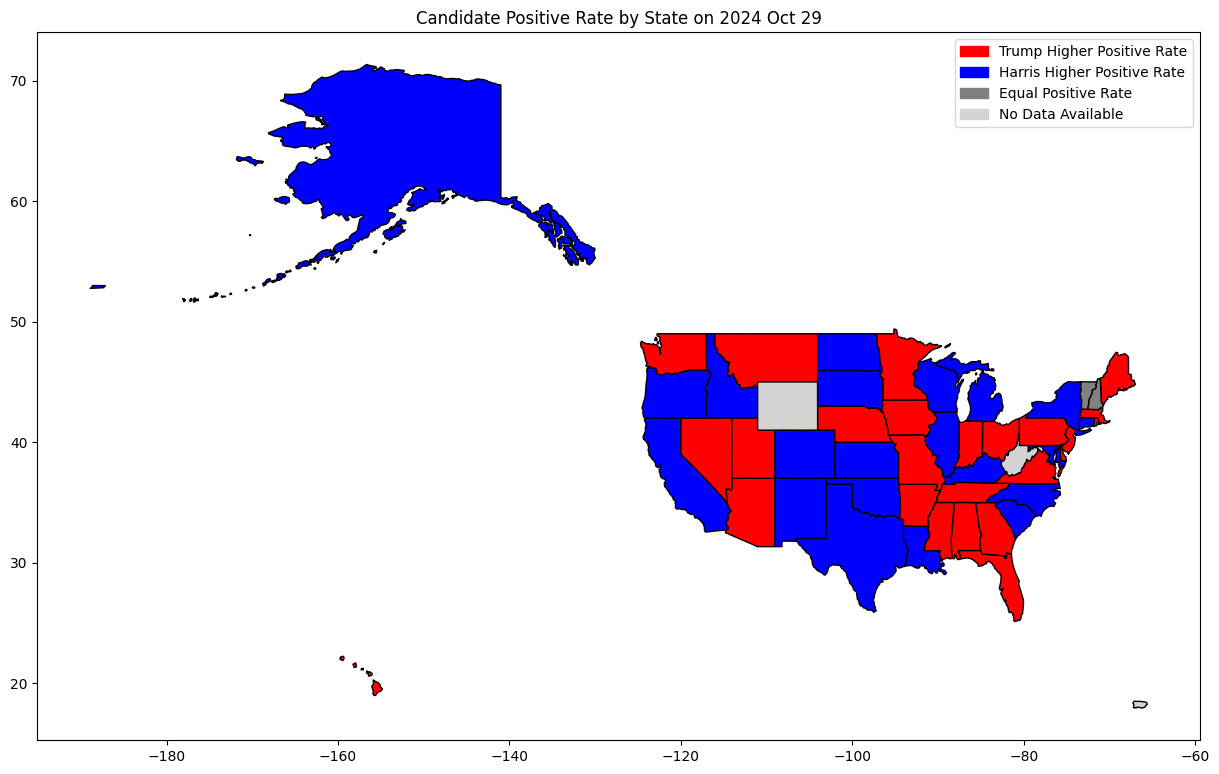

In [0]:
from pyspark.sql import functions as F

df_pivoted = (spark.table("candidate_support_by_state")
              .groupBy("state")
              .pivot("candidate", ["trump", "harris"])
              .agg(
                  F.first("positive_rate").alias("positive_rate"),
                  F.first("tweet_count").alias("tweet_count")
              )
              .select(
                  "state",
                  F.col("trump_positive_rate").alias("trump_positive_rate"),
                  F.col("trump_tweet_count").alias("trump_tweet_count"),
                  F.col("harris_positive_rate").alias("harris_positive_rate"),
                  F.col("harris_tweet_count").alias("harris_tweet_count")
              )
)

df_pivoted = df_pivoted.toPandas()
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Download GeoJSON data for US states
url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
states = gpd.read_file(url)

state_abbr_to_name = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California", "CO": "Colorado",
    "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia", "HI": "Hawaii", "ID": "Idaho",
    "IL": "Illinois", "IN": "Indiana", "IA": "Iowa", "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana",
    "ME": "Maine", "MD": "Maryland", "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi",
    "MO": "Missouri", "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire", "NJ": "New Jersey",
    "NM": "New Mexico", "NY": "New York", "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma",
    "OR": "Oregon", "PA": "Pennsylvania", "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota",
    "TN": "Tennessee", "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia", "WA": "Washington",
    "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming"
}

df_pivoted['state_full'] = df_pivoted['state'].map(state_abbr_to_name)

states = states.merge(df_pivoted, left_on='name', right_on='state_full', how='left')

def get_color(row):
    if pd.isna(row['trump_positive_rate']) or pd.isna(row['harris_positive_rate']):
        return 'lightgray'  # No data available
    elif row['trump_positive_rate'] > row['harris_positive_rate']:
        return 'red'  # Trump-supporting state
    elif row['harris_positive_rate'] > row['trump_positive_rate']:
        return 'blue'  # Harris-supporting state
    else:
        return 'gray'  

states['color'] = states.apply(get_color, axis=1)


fig, ax = plt.subplots(1, 1, figsize=(15, 10))
states.plot(ax=ax, color=states['color'], edgecolor='black')

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Trump Higher Positive Rate')
blue_patch = mpatches.Patch(color='blue', label='Harris Higher Positive Rate')
gray_patch = mpatches.Patch(color='gray', label='Equal Positive Rate')
lightgray_patch = mpatches.Patch(color='lightgray', label='No Data Available')
plt.legend(handles=[red_patch, blue_patch, gray_patch, lightgray_patch])

plt.title("Candidate Positive Rate by State on 2024 Oct 29")
plt.show()




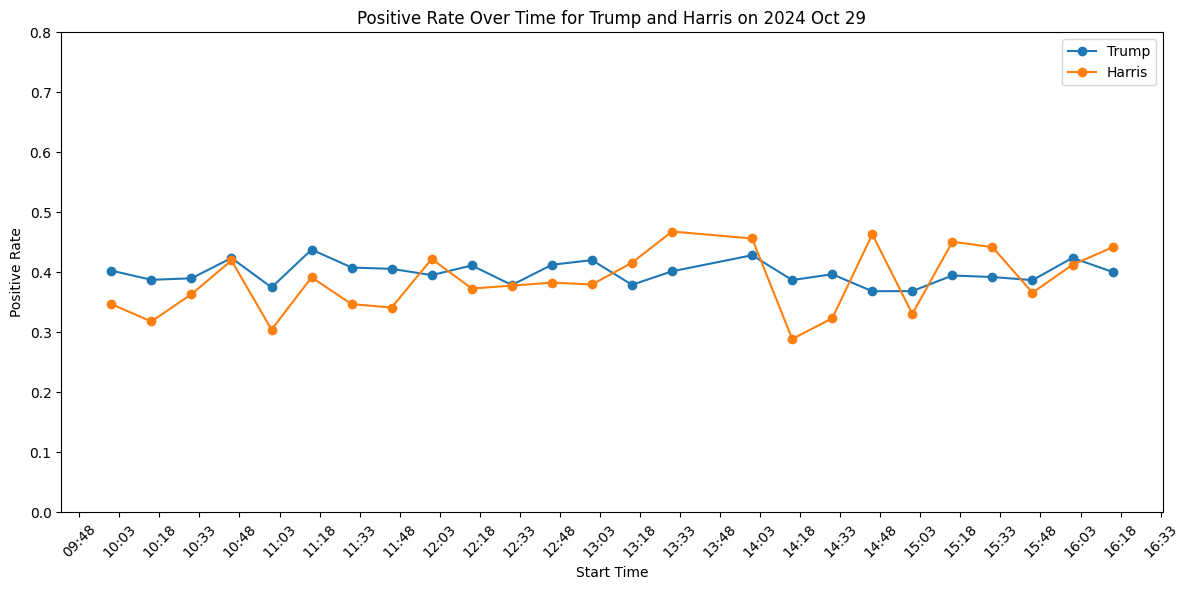

In [0]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
df = spark.read.table("candidate_support_over_time")

pandas_df = df.toPandas()
pandas_df = pandas_df.sort_values(by='start')


trump_data = pandas_df[pandas_df['candidate'] == 'trump']
harris_data = pandas_df[pandas_df['candidate'] == 'harris']

plt.figure(figsize=(12, 6))

plt.plot(trump_data['start'], trump_data['positive_rate'], label='Trump', marker='o')
plt.plot(harris_data['start'], harris_data['positive_rate'], label='Harris', marker='o')

plt.title('Positive Rate Over Time for Trump and Harris on 2024 Oct 29')
plt.xlabel('Start Time')
plt.ylabel('Positive Rate')

plt.legend()


plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xticks(rotation=45)

plt.ylim(0, 0.8)
plt.tight_layout()
plt.show()
